# 패키지 import & setting

In [45]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import time
from bs4 import BeautifulSoup

import re

import pandas as pd
import numpy as np

In [17]:
# 웹 드라이버 설정
## Chrome 옵션 설정
chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument("--headless")  # 브라우저를 백그라운드에서 실행
chrome_options.add_argument("--lang=ko")

## 웹 드라이버 설정 및 실행
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

# 구글 플레이스토어 리뷰 크롤링

In [106]:
# Chrome 옵션 설정 (한국어로 설정)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--lang=ko")

# 웹 드라이버 설정 및 실행
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

try:
    # 1. URL 설정
    url = 'https://play.google.com/store/apps/details?id=com.elevenst&hl=ko'
    driver.get(url)
    
    # 2. 평가 및 리뷰 페이지 전환
    ## 버튼 로딩 대기
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, '#yDmH0d > c-wiz.SSPGKf.Czez9d > div > div > div:nth-child(1) > div > div.wkMJlb.YWi3ub > div > div.qZmL0 > div:nth-child(1) > c-wiz:nth-child(5) > section > header > div > div:nth-child(2) > button'))
    )
    ## 전환 버튼 클릭
    driver.find_element(By.CSS_SELECTOR, '#yDmH0d > c-wiz.SSPGKf.Czez9d > div > div > div:nth-child(1) > div > div.wkMJlb.YWi3ub > div > div.qZmL0 > div:nth-child(1) > c-wiz:nth-child(5) > section > header > div > div:nth-child(2) > button').click()

    # 3. Review 가져오기
    # 리뷰 최신순 정렬 
    
    # element = driver.find_element(By.ID, "sortBy_1")
    # driver.execute_script("arguments[0].setAttribute('id', 'sortBy_2')", element)

    # 드롭다운 버튼 클릭 (드롭다운 메뉴를 열어야 합니다)
    dropdown_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, '#sortBy_1'))
    )
    dropdown_button.click()

    # 최신순 필터 선택
    sort_by_latest = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, '#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi.Vk3ZVd > div.JPdR6b.e5Emjc.ah7Sve.qjTEB > div > div > span:nth-child(2)'))
    )
    sort_by_latest.click()

    
    # 스크롤을 반복적으로 내려서 모든 리뷰 로드
    review_container = WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, '#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi.Vk3ZVd'))
    )
    last_height = driver.execute_script("return arguments[0].scrollHeight", review_container)
    print(last_height)
    i=0
    for i in range(500):
        driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", review_container)
        time.sleep(2)  # 페이지 로딩 대기

        new_height = driver.execute_script("return arguments[0].scrollHeight", review_container)
        last_height = new_height
        i+=1

    # 페이지 소스 가져오기
    page_source = driver.page_source
finally:
    # 브라우저 닫기
    # driver.quit()
    print('done')

8393
done


In [107]:
# BeautifulSoupt으로 HTML 파싱
soup = BeautifulSoup(page_source, 'html.parser')
reviews = soup.find_all('div', 'RHo1pe')

review_data = []
for review in reviews:
    # 리뷰 이름, 날짜, 별점, 텍스트 추출
    reviewer_name = review.find('div', attrs={'class':'X5PpBb'}).text
    review_date = review.find('span', attrs={'class':'bp9Aid'}).text
    review_score = review.find('div', attrs={'role':'img'})['aria-label']
    review_text = review.find('div', attrs={'class':'h3YV2d'}).text

    # 텍스트에서 별점만 추출
    score_num = re.search(r'만점에 (\d+)개를 받았습니다', review_score).group(1)
   
    # review_data에 저장
    review_data.append({
        'name': reviewer_name,
        'date': review_date,
        'score': score_num,
        'review': review_text
    })

In [108]:
# 리뷰 데이터 출력 (확인용)
for review in review_data:
    print(review)
    print()

{'name': '김향순', 'date': '2024년 7월 6일', 'score': '3', 'review': '몇일전부터 알림 누르면 없는 페이지가나온다.오류인가요?추천특가도 같음'}

{'name': '이애자', 'date': '2024년 7월 6일', 'score': '5', 'review': '싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^'}

{'name': '대중김', 'date': '2024년 7월 5일', 'score': '4', 'review': '소음이 적어서 좋아요^^'}

{'name': '천성호', 'date': '2024년 7월 5일', 'score': '5', 'review': '좋음'}

{'name': '김가희', 'date': '2024년 7월 5일', 'score': '1', 'review': '미국아마존 배송이라면서 대부분 중국상품을 팔고있네 미국내에서 판매중인상품&미국브랜드를 팔아야 되는거아니야? 중국상품 살거면 알리나 테무에서 사지.굳이 비싸게 11번가아마존에서 살이유가 없자나. 모르는 브랜드적힌거는 전부다 중국꺼다. 특히 화장품들. 11번가는 중국꺼팔지말고 미국꺼만 팔자. 브랜드라고 적힌것들 검색해봐도 아무런정보도 얻을수가없다. 화장품브랜드에 적힌거는 브랜드가 아니고 샐러샵 이름이더라.ㅋㅋ 정보 고지 똑바로 하길. 화장품상세설명에 제조사. 제조국 표기해주기바람.'}

{'name': 'spirit wndrg', 'date': '2024년 7월 5일', 'score': '3', 'review': '쿠팡에서는 와우 아니면 추가로 상품구매하라고만 하고 결제진행이 안돼서 포기하고 다시 12번가로 돌아왔다. 가격차이가 없네 뭐.'}

{'name': '혜일문', 'date': '2024년 7월 5일', 'score': '5', 'review': '좋아요'}

{'name': 'Yuri Kang', 'date': '2024년 7월 5일', 'score': '5', 'review': '직구샵들이 좋아요'}

{'n

In [109]:
# 데이터 프레임으로 변환 
review_df = pd.DataFrame(review_data)

# score 컬럼: to integer
review_df['score'] = review_df['score'].apply(lambda x: int(x))

# date 컬럼: to datetime
review_df['date'] = pd.to_datetime(review_df['date'], format='%Y년 %m월 %d일')

In [58]:
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [110]:
review_df

,name,date,score,review
0,김향순,2024-07-06,3,몇일전부터 알림 누르면 없는 페이지가나온다.오류인가요?추천특가도 같음
1,이애자,2024-07-06,5,싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^
2,대중김,2024-07-05,4,소음이 적어서 좋아요^^
3,천성호,2024-07-05,5,좋음
4,김가희,2024-07-05,1,미국아마존 배송이라면서 대부분 중국상품을 팔고있네 미국내에서 판매중인상품&미국브랜드...
...,...,...,...,...
5275,남조영운,2023-07-07,4,편리성이 뛰어남.
5276,조은주,2023-07-06,5,포인트가 적절하게 쌓여 참유용하게 쓸수있네요~
5277,정서목,2023-07-06,4,구매하였는데 사용 잘하께요
5278,정우선,2023-07-06,5,항상 좋아요


In [111]:
# csv 파일로 저장 
review_df.to_csv('./dataset/review_rawdata_최신순_20230706_20240706.csv', encoding='utf-8-sig')

# 리뷰 데이터 확인

## 0. 데이터 프레임 가공

In [112]:
# 원본 dataframe copy
proc_df = review_df.copy()

In [113]:
# 1) 분기 컬럼 생성 
## 분기 추출 함수 
def get_quarter(date):
    year = date.year
    quarter = date.quarter
    return f"{year}_Q{quarter}"

## 분기 변환
proc_df['quarter'] = proc_df['date'].apply(lambda x: get_quarter(x))

In [114]:
## 2) 날짜 최신순으로 재정렬 
proc_df = proc_df.sort_values(by='date', ascending=False)

In [115]:
proc_df

,name,date,score,review,quarter
0,김향순,2024-07-06,3,몇일전부터 알림 누르면 없는 페이지가나온다.오류인가요?추천특가도 같음,2024_Q3
1,이애자,2024-07-06,5,싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^,2024_Q3
7,Yuri Kang,2024-07-05,5,직구샵들이 좋아요,2024_Q3
10,DH B,2024-07-05,1,3개월을넘는시간동안 13분씩 광고를 보게하고 매일 3번씩 정해진 시간에 출첵같이 먹...,2024_Q3
9,Amelia,2024-07-05,5,요즘은 뭐든 셀프로하는게 유행인 것 같아요 제모도 집에서 셀프로하는 기계들이 좋은게...,2024_Q3
...,...,...,...,...,...
5263,Ji Ya,2023-07-07,5,11번가 어플이 포인트 할인도 좋고 가장 편하긴한데 (쿠팡안씀) 가끔 G마켓이나 네...,2023_Q3
5276,조은주,2023-07-06,5,포인트가 적절하게 쌓여 참유용하게 쓸수있네요~,2023_Q3
5277,정서목,2023-07-06,4,구매하였는데 사용 잘하께요,2023_Q3
5278,정우선,2023-07-06,5,항상 좋아요,2023_Q3


## 1. 평균 평점

### 1) 전체기간 평균평점

In [116]:
# 전체 기간 range 확인 
print(f'리뷰 데이터 기간: {review_df["date"].min().strftime("%Y-%m-%d")} ~ {review_df["date"].max().strftime("%Y-%m-%d")}')
print(f'리뷰 평균평점: {np.round(review_df["score"].mean(), 2)}')

리뷰 데이터 기간: 2023-07-06 ~ 2024-07-06
리뷰 평균평점: 4.56


### 2) 분기별 평균평점

In [117]:
# 2) 분기별 평균평점
quarter_grouped = proc_df.groupby('quarter')
display(quarter_grouped[['score']].count())
display(quarter_grouped[['score']].mean())

,score
quarter,
2023_Q3,894
2023_Q4,2621
2024_Q1,878
2024_Q2,830
2024_Q3,57


,score
quarter,
2023_Q3,4.458613
2023_Q4,4.616177
2024_Q1,4.482916
2024_Q2,4.575904
2024_Q3,4.368421


In [ ]:
# 분기별 평균평점 시각화


## 2. 긍정리뷰 vs 부정리뷰 분석
- 긍정리뷰: 평점 4~5점
- 부정리뷰: 평점 1~3점

In [120]:
proc_df.sort_values(by=['score', 'date'], ascending=False)

,name,date,score,review,quarter
1,이애자,2024-07-06,5,싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^,2024_Q3
7,Yuri Kang,2024-07-05,5,직구샵들이 좋아요,2024_Q3
9,Amelia,2024-07-05,5,요즘은 뭐든 셀프로하는게 유행인 것 같아요 제모도 집에서 셀프로하는 기계들이 좋은게...,2024_Q3
8,김주현,2024-07-05,5,비가 계속 내리고 흐리니까 가족 모두 크록스 신으려고 샀어요 젖은 양말로 하루종일 ...,2024_Q3
11,이미지,2024-07-05,5,매번 생수 재주문하고 있는데 항상 가격이 참 좋은 것 같아요 많이 주문할 땐 기사님...,2024_Q3
...,...,...,...,...,...
5262,이차영,2023-07-08,1,로딩될때 너무 느려요ㅜ,2023_Q3
5261,신돌석,2023-07-08,1,11번가~~!! 좋습니다~!!,2023_Q3
5251,so “개뚜이” k,2023-07-08,1,개인정보 유출에 해당 되는거 아닌가여 누구나 아무나 볼수 있다,2023_Q3
5268,비내리는 오후,2023-07-07,1,솔직하게 제품찾기 힘듬..원하는거 검색하면 개고양이제품이나옴. 내가 동물임? 문재인...,2023_Q3


In [122]:
# 리뷰 분류: review category 열 생성
proc_df['review_category'] = proc_df['score'].apply(lambda x: 'positive' if x >= 4 else 'negative')

In [123]:
proc_df

,name,date,score,review,quarter,review_category
0,김향순,2024-07-06,3,몇일전부터 알림 누르면 없는 페이지가나온다.오류인가요?추천특가도 같음,2024_Q3,negative
1,이애자,2024-07-06,5,싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^,2024_Q3,positive
7,Yuri Kang,2024-07-05,5,직구샵들이 좋아요,2024_Q3,positive
10,DH B,2024-07-05,1,3개월을넘는시간동안 13분씩 광고를 보게하고 매일 3번씩 정해진 시간에 출첵같이 먹...,2024_Q3,negative
9,Amelia,2024-07-05,5,요즘은 뭐든 셀프로하는게 유행인 것 같아요 제모도 집에서 셀프로하는 기계들이 좋은게...,2024_Q3,positive
...,...,...,...,...,...,...
5263,Ji Ya,2023-07-07,5,11번가 어플이 포인트 할인도 좋고 가장 편하긴한데 (쿠팡안씀) 가끔 G마켓이나 네...,2023_Q3,positive
5276,조은주,2023-07-06,5,포인트가 적절하게 쌓여 참유용하게 쓸수있네요~,2023_Q3,positive
5277,정서목,2023-07-06,4,구매하였는데 사용 잘하께요,2023_Q3,positive
5278,정우선,2023-07-06,5,항상 좋아요,2023_Q3,positive


In [124]:
# 긍정 리뷰 df 생성 
positive_reviews = proc_df[proc_df['review_category']=='positive']
positive_reviews

,name,date,score,review,quarter,review_category
1,이애자,2024-07-06,5,싱싱 달고 넘맛있음 두번째 구매임 잘먹어읍니다 감사합니다^-^,2024_Q3,positive
7,Yuri Kang,2024-07-05,5,직구샵들이 좋아요,2024_Q3,positive
9,Amelia,2024-07-05,5,요즘은 뭐든 셀프로하는게 유행인 것 같아요 제모도 집에서 셀프로하는 기계들이 좋은게...,2024_Q3,positive
8,김주현,2024-07-05,5,비가 계속 내리고 흐리니까 가족 모두 크록스 신으려고 샀어요 젖은 양말로 하루종일 ...,2024_Q3,positive
11,이미지,2024-07-05,5,매번 생수 재주문하고 있는데 항상 가격이 참 좋은 것 같아요 많이 주문할 땐 기사님...,2024_Q3,positive
...,...,...,...,...,...,...
5264,십원짜리티,2023-07-07,5,넘버원,2023_Q3,positive
5263,Ji Ya,2023-07-07,5,11번가 어플이 포인트 할인도 좋고 가장 편하긴한데 (쿠팡안씀) 가끔 G마켓이나 네...,2023_Q3,positive
5276,조은주,2023-07-06,5,포인트가 적절하게 쌓여 참유용하게 쓸수있네요~,2023_Q3,positive
5277,정서목,2023-07-06,4,구매하였는데 사용 잘하께요,2023_Q3,positive


In [125]:
# 부정 리뷰 df 생성 
negative_reviews = proc_df[proc_df['review_category']=='negative']
negative_reviews

,name,date,score,review,quarter,review_category
0,김향순,2024-07-06,3,몇일전부터 알림 누르면 없는 페이지가나온다.오류인가요?추천특가도 같음,2024_Q3,negative
10,DH B,2024-07-05,1,3개월을넘는시간동안 13분씩 광고를 보게하고 매일 3번씩 정해진 시간에 출첵같이 먹...,2024_Q3,negative
5,spirit wndrg,2024-07-05,3,쿠팡에서는 와우 아니면 추가로 상품구매하라고만 하고 결제진행이 안돼서 포기하고 다시...,2024_Q3,negative
4,김가희,2024-07-05,1,미국아마존 배송이라면서 대부분 중국상품을 팔고있네 미국내에서 판매중인상품&미국브랜드...,2024_Q3,negative
16,바닐라라떼 (아이스),2024-07-04,1,11번가가 적자의 늪에 빠진 이유 1. 할인쿠폰이 파격적으로 센거 나오지 않는 이상...,2024_Q3,negative
...,...,...,...,...,...,...
5261,신돌석,2023-07-08,1,11번가~~!! 좋습니다~!!,2023_Q3,negative
5260,SEAN KIM,2023-07-08,2,광고 알림 꺼도 계속 푸쉬알림 광고가 와 앱 삭제합니다,2023_Q3,negative
5251,so “개뚜이” k,2023-07-08,1,개인정보 유출에 해당 되는거 아닌가여 누구나 아무나 볼수 있다,2023_Q3,negative
5268,비내리는 오후,2023-07-07,1,솔직하게 제품찾기 힘듬..원하는거 검색하면 개고양이제품이나옴. 내가 동물임? 문재인...,2023_Q3,negative


#### 워드클라우드 생성

In [152]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Okt

# 워드클라우드 생성 함수
## input = df
## print = wordcloud
## return = text
def make_wordcloud(df):
    # 한국어 텍스트 추출 및 형태소 분석 
    okt = Okt()
    text = ' '.join(df['review']) 
    tokens = okt.nouns(text) # 명사만 추출 
    text = ' '.join(tokens)  # 단어 빈도수 게산 

    # 불용어 목록 지정 
    stopwords = set([
        '번가', '절', '때', '등', '이번', '더', '생각', '늘', '사용', '좀', '걸', '보', '수', '곳', '아주',
        '상품', '정말', '항상', '앱', '진짜', '나', '거의', '것', '저', '가끔', '일절', '쇼핑', '구매', '이용',
        '이유', '무엇', '번', '역시', '보고', '전', '여러', '일단', '점',
        '왜', '점점', '거', '개', '하나', '후', '요', '뭐', '임', '안', '타', '예전', '오늘', '또', '다시', '한번',
        '다른', '말', '차라리', '정도', '요즘', '건가', '때문', '시', '그', '그냥', '자꾸', '갑자기', '내', '함', '해도', 
        '이런', '하라', '무슨', '기타', '누가', '느낌', '이건', '창', '미리', '자주', '지금', '여기', '도', '게', '기회', '제',
        '몇', '시', '모두'
    ])

    # 워드 클라우드 생성 
    wordcloud = WordCloud(
        font_path='/Library/Fonts/Arial Unicode.ttf', 
        width=800, 
        height=800, 
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    # word cloud 시각화
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    return text

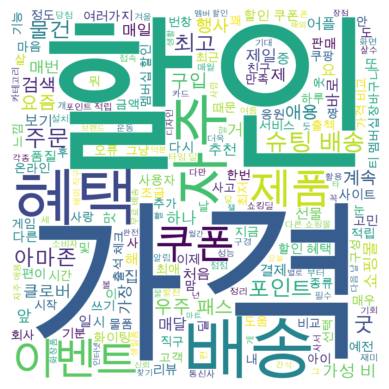

'싱싱 달 두번째 구매 임 읍 직구 요즘 뭐 셀프 유행 것 제모 집 셀프 기계 은 저 구매 샵 만 비 계속 가족 모두 록스 양말 하루 종일 매번 생수 재 주문 항상 가격 것 주문 땐 기사 기도 소음 매번 편의점 견과류 차라리 왕창 주문 번가 주문 가격 제로 음료수 뭔가 매번 기전 슈팅 배송 구매 이번 코카콜라 제로로 주문 신뢰 믿음 첫 상담 구매 곳 번가 회사 출근 길 메 커피 아침 주문 점심 때 기프티콘 때 구매 사용 얼굴 부쩍 친구 추천 에스트 크림 구매 여름 도 걸 아이 여름방학 곧 간식 준비 장난감 여행 갈곳도 구매 아이 아주 양 엄마 주문 맛맛맛 맛 이케아 자주 구경 은근 금액 보이 자주 마침 출근 세 구매 굿굿 실속 맛 쇼핑 사보 맘 사용 창문 에어컨 설치 진짜 신세계 제 방 에어컨 설치 창문 구매 설치 건데 고양이 기 거실 이어컨 제방 냉기 부모님 논의 제방 창문 에어컨 달기 로 구매 구매 것 이용 원활 근육통 작용 관절통 정도 반응 시간 덧 마사지 안해 잠시 통증 엄마 하나 사 이번 것 주문 요즘 선풍기 중 일부 날개 선풍기 아이 집 거 구매 바람 좀 마음 곳 가성 비 상품 요 조금 사이트 할인 번가 구입 요 진심 일절 일도 자주 애용 할인 여러 쇼핑 앱 번가 회사 케어 범위 문제 스트레스 처리 수 배송 부탁 번가 상품 것 자주 애용 앞 더 사람 다른 쇼핑 앱 배송 편이 가격 워낙 쇼핑 앱 신뢰 사용 화이팅 항상 장가 주문 쿠폰 구매 처음 요 퇴근 후 바로 쇼핑 제일 믿음 번가 최고 늘 신용 애용 번가 사용 정보 상품 발판 가성 비 최고 가격 상품 질도 아주 사용 고객 불만 처리 항상 기분 쇼핑 항상 제품 가성 비도 읍 항상 가성 비 비 물맛 강원 평창 수 배송 편이 가격 신뢰 추천 짱 맛 향 향 항상 제품 레드 향 강 에어 프라이어 살 고민 지인 말 구매 리뷰 워낙 가격 가끔 상품 구매 견과류 간식 때 또 키티 게임 때 구매 요즘 맛 개 구매 진짜 여름 옷 사도 사도 모 것 며칠 전 또 주문 가격 부담 구매 수 오류 회사 범위 타 사이트 바로 

In [135]:
# 긍정리뷰 워드클라우드
make_wordcloud(positive_reviews)

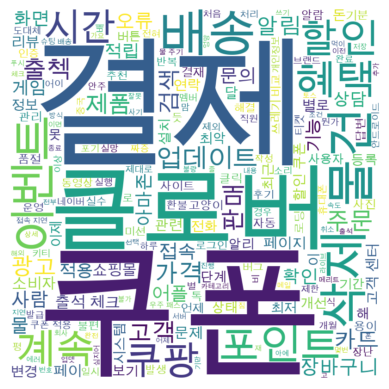

'일전 알림 페이지 오류 추천 특 가도 개월 시간 동안 광고 매일 번 정해진 시간 출첵 먹이 물건 구입 몇 번 이 걸 이제 마리 메 커피 먹기 리도 아이스크림 아주 얘기 뿐 고객 타 번 문의 대책 정해진 사람 속도 말 저 개월 단 하루 쉬 매일 한번 도 물건 몇 번 정말 리기 위 이벤트 고객 타 짜증 더 유발 문제해결 위해 메일 래서 고객 타 메일 시간 낭비 진짜 정신 회사 개월 투자 안주 이벤트 세상 어디 메일 용도 문제해결 의지 모습 동네 수퍼 고객 리기 재미 쿠팡 와우 추가 상품 구매 만 결제 진행 포기 다시 번가 가격 차이 뭐 미국 아마존 배송 면서 대부분 중국 상품 팔고 미국 내 판매 상품 미국 브랜드 아야 중국 상품 알리 테무 사지 굳이 번가 아마존 살이 유가 브랜드 전부 중국 화장품 번가 중국 팔지 미국 팔자 브랜드 검색 정보 화장품 브랜드 브랜드 샵 정보 고지 똑바로 화장품 설명 조사 조국 표기 바람 번가 적자 늪 이유 할인 쿠폰 파격 이상 네이버 최저 검색 쿠팡 배송 시스템 구축 제품 다양성 부족함 신선 식품 등 장보기 기능 추가 기존 마트 온라인 장보 기기 기능 초월 쿠팡 기타 장보기 어플 새벽 배송 키티즈 창렬 서비스 돌파구 마련 함 사이트 상품 시스템 비교 번가 접속 이유 다른 어플 상품 개 동안 키티 첫 고양이 정도 브랜드 홍보 번가 데이 쿠폰 뿌리 제대로 할인 쿠폰 사람 번가 꼭 인식 현실 네이버 최저 아주 굳이 번가 쇼핑 한단 생각 안듬 평 번가 쿠팡 알리 테무 글렀다 택배 비 장난 셨 다음 앱 동영상 플레이어 미니 모드 제공 동영상 키티 왜 자꾸만 여기 평가 건가 번가 별로 네이버 쿠팡 최고 왜 계속 실행 고양이 왜 저 부터 최근 번가 이용 고객 한명인 데 므 문제점 오늘 결제 지연 진짜 어이 거좀 해 게임 접속 버그 수정 햇 언제 상품 재고 품절 상품 오른쪽 하단 최근 상품 목록 안보 보이 해 원래 장바구니 상품 보관 기간 최대 최대 예고 변경 단축 불편 불만 임 지난 버전 때 휴대전화 상태 및 권한 요구 검색 바 최근 상품 최근

In [153]:
# 부정리뷰 워드클라우드
make_wordcloud(negative_reviews)

#### 긍정, 부정 리뷰 csv 저장 

In [154]:
positive_reviews.to_csv('./dataset/긍정리뷰_20230706_20240706.csv', encoding='utf-8-sig')
negative_reviews.to_csv('./dataset/부정리뷰_20230706_20240706.csv', encoding='utf-8-sig')